In [1]:
%matplotlib inline
import numpy as np
import qutip as qt

import time

from matplotlib import pyplot as plt
import sys
import amolib as alib

plt.style.use('dark_background')
plt.rcParams['font.size'] = 12

In [2]:
c1 = qt.Qobj([[1],[0],[0]]);c2 = qt.Qobj([[0],[1],[0]]);c3 = qt.Qobj([[0],[0],[1]])
s11 = c1*c1.trans(); s12 = c1*c2.trans(); s13 = c1*c3.trans();
s21 = c2*c1.trans(); s22 = c2*c2.trans(); s23 = c2*c3.trans();
s31 = c3*c1.trans(); s32 = c3*c2.trans(); s33 = c3*c3.trans();

# Numerical Study of EIT with QuTIP

## Basic EIT Hamilitonian

We use the following convention for specifying the atomic levels and optical fields (see below): the excited state is $\vert 1\rangle$, the pump is called the "coupling field" with strength $\Omega_c$ couples out of state $\vert 1\rangle$. The signal field $\Omega_s$ couples out of state $\vert 3\rangle$ and is set as the zero point for energy. Spontaneous emission couples out of the excited state and (for now) we assume that the rates are equal and each given by $\Gamma$. There is also population exchange with rate $\gamma$ between the ground states. 

![EIT Scheme Used here](EIT_scheme.png)

In this case, the Hamiltonian for the system is:

$$
\hat{H} = -\hbar\begin{pmatrix} \Delta_s & \Omega_c & \Omega_s \\  \Omega_c^* & \delta & 0 \\ \Omega_c^* & 0 & 0 \end{pmatrix}
$$

Where $\delta = \Delta_s-\Delta_c$

As a first step, consider the simple, non-broadened spectrum, seen by scanning the probe field. 

Note that in the approximation of a weak signal field, the population will reside almost entirely in state $\vert3\rangle$ and the state is approximately pure. Then we can solve for the steady state:

$$
\partial_t\vert\psi\rangle =\frac{i}{\hbar}\begin{pmatrix} \Delta_s & \Omega_c & \Omega_s \\  \Omega_c^* & \delta & 0 \\ \Omega_c^* & 0 & 0 \end{pmatrix}
\begin{pmatrix}1 \\ \psi_2\\\psi_3\end{pmatrix} -  \begin{pmatrix}\Gamma \\ \gamma \\0\end{pmatrix} \approx \overline{0}
$$

so that $\psi_1 \approx \rho_{13}\propto\chi$ and thus

$$
\chi \approx \frac{\delta + i\gamma}{\vert\Omega_c\vert^2 - (\Delta + i\Gamma)(\delta + i\gamma)}
$$

As a first step, we can verify that the numerical solution via QuTIP agrees with this in the limit of $\vert\Omega_c\vert\ll\vert\Omega_s\vert$:

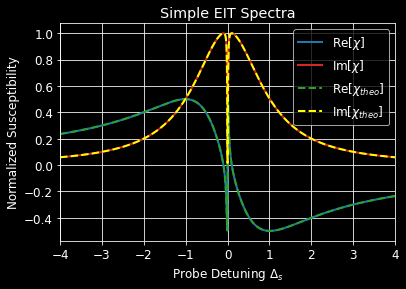

In [3]:
G = 1
Wc = .10*G
Ws = 1e-6 *G
Dc = 0*1.2*G

g = 0*G*(1e-6)

def get_chi3lev_analytic(DetS,RabiC,DetC=0,prefactor=1,Gamma = 1,decoh = 0):
    return prefactor*(DetS - DetC + 1j*decoh)/(np.abs(RabiC)**2 - (DetS + 1j*G)*(DetS - DetC + 1j*decoh))

def get_chi3lev(frk,RabiC,DetC=0,RabiS=1e-8,prefactor=1,Gamma = 1,decoh = 0):
    L12 = Gamma*(qt.spre(s21)*qt.spost(s12) - 0.5*qt.spre(s11) - 0.5*qt.spost(s11))
    L13 = Gamma*(qt.spre(s31)*qt.spost(s13) - 0.5*qt.spre(s11) - 0.5*qt.spost(s11))
    L23 = decoh*(qt.spre(s32)*qt.spost(s23) - 0.5*qt.spre(s22) - 0.5*qt.spost(s22))
    L32 = decoh*(qt.spre(s23)*qt.spost(s32) - 0.5*qt.spre(s33) - 0.5*qt.spost(s33))
    
    if np.isscalar(frk):
        H = -(frk*s11 + RabiC*s12 + RabiS*s13 + np.conj(RabiC)*s21 + np.conj(RabiS)*s31 + (frk - DetC)*s22)
        rho = qt.steadystate(H,[L12,L13,L23,L32])
        chi3 =  rho[0,2]/RabiS    
    else:
        chi3 = np.zeros(len(frk))*1j
        for k in range(len(frk)):
            H = -(frk[k]*s11 + RabiC*s12 + RabiS*s13 + np.conj(RabiC)*s21 + np.conj(RabiS)*s31 + (frk[k] - DetC)*s22)
            rho = qt.steadystate(H,[L12,L13,L23,L32])
            chi3[k] = rho[0,2]/RabiS
    return chi3*prefactor


Nfreq = int(4e3)

spn = 5*G
Dets = np.linspace(-1,1,Nfreq)*spn

chi = get_chi3lev(Dets,DetC = Dc,RabiC = Wc,RabiS=Ws/100,Gamma = G)


fig,ax = plt.subplots()

ax.plot(Dets,np.real(chi),color = 'tab:blue',label = 'Re[$\chi$]',lw=2)
ax.plot(Dets,np.imag(chi),color = 'tab:red',label = 'Im[$\chi$]',lw=2)

chi_anl = get_chi3lev_analytic(Dets,Wc,DetC = Dc)

ax.plot(Dets,np.real(chi_anl),'--',color = 'tab:green',label = 'Re[$\chi_{theo}$]',lw=2)
ax.plot(Dets,np.imag(chi_anl),'--',color = 'yellow',label = 'Im[$\chi_{theo}$]',lw=2)


ax.grid(True)
ax.legend()
ax.set_title('Simple EIT Spectra')
ax.set_xlim(-4*G,4*G)
ax.set_xlabel('Probe Detuning $\Delta_s$')
ax.set_ylabel('Normalized Susceptibility');

## Time dependence: Transient EIT

We can explore time dependent solution using the same method as for the 2 level atom.

Since there are multiple fields with multiple detunings etc, we have multiple parameters to explore. For now, explore the difference between ramping on the pump with a steady state signal and ramping up the signal with the pump always on.

We will assume that the at time $t=0$ we have a statistical mixture up ground states, with equal probability of being in states $\vert2\rangle$ and $\vert3\rangle$, i.e that $\rho_0 = 0.5\hat{\sigma}_{22} + 0.5\hat{\sigma}_{33}$.

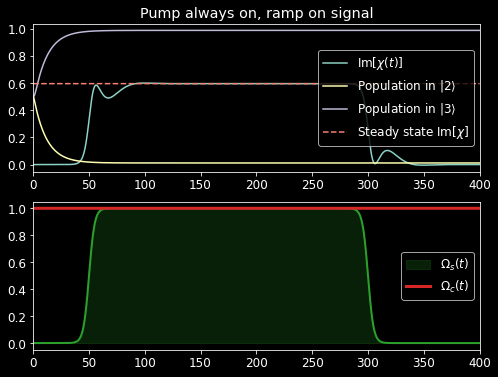

In [4]:
G = 1
Ds = .1*G
Wc = .30*G
Ws = 1e-3 *G
Dc = 0*G

g = G*(1e-3)

Nt = int(4e3)

# Define time Vector
t = np.linspace(0,1,Nt)*400/G

# Initial condition
rho0 = (s22 + s33)/2

# Define time Dependant coefficients
# SIGMOID FUNCTION

t_on = 50
t_off = 300
sig_wd = 2.5


L12 = G*(qt.spre(s21)*qt.spost(s12) - 0.5*qt.spre(s11) - 0.5*qt.spost(s11))
L13 = G*(qt.spre(s31)*qt.spost(s13) - 0.5*qt.spre(s11) - 0.5*qt.spost(s11))
L23 = g*(qt.spre(s32)*qt.spost(s23) - 0.5*qt.spre(s22) - 0.5*qt.spost(s22))
L32 = g*(qt.spre(s23)*qt.spost(s32) - 0.5*qt.spre(s33) - 0.5*qt.spost(s33))


def pulse(t,dummy=False):
    global G, Ws
    return Ws*(1/(1+np.exp(-G*(t-t_on/G)/sig_wd)) - 1/(1+np.exp(-G*(t-t_off/G)/sig_wd)))

# Construct Hamiltonian
H0 = -(Ds*s11 + Wc*s12 + np.conj(Wc)*s21 + (Ds - Dc)*s22)
H1 = -(s13 + s31)
H = [H0,[H1,pulse]]

# ... and solve
result = qt.mesolve(H, rho0,t,[L12,L13,L23,L32],[s31,s22,s33])

fig,(ax1,ax2) = plt.subplots(2,1,figsize = (8,6))

ax1.plot(result.times,np.imag(result.expect[0]/Ws),label = 'Im[$\chi(t)$]')
ax1.plot(result.times,np.real(result.expect[1]),label = 'Population in $\\vert2\\rangle$')
ax1.plot(result.times,np.real(result.expect[2]),label = 'Population in $\\vert3\\rangle$')



# ax2.fill_between(t,np.ones(Nt),alpha = .6,color = 'white')
ax2.fill_between(t,pulse(t)/Ws,alpha = .2,label = '$\Omega_s(t)$',color = 'tab:green')
ax2.plot(t,pulse(t)/Ws,lw =2,color = 'tab:green')
ax2.plot(t,np.ones(Nt),color = 'tab:red',lw=3,label = '$\Omega_c(t)$')

Hss = -(Ds*s11 + Wc*(s12 + s21) + Ws*(s13 + s31) + (Ds - Dc)*s22)
rho_ss = qt.steadystate(Hss,[L12,L13,L23,L32])
chi_ss = rho_ss[0,2]/Ws

ax1.plot(result.times,np.ones(Nt)*np.imag(chi_ss),'--',label = 'Steady state Im[$\chi$]')

ax1.set_xlim(0,400)
ax2.set_xlim(0,400)

ax1.set_title('Pump always on, ramp on signal')

ax1.legend()
ax2.legend();

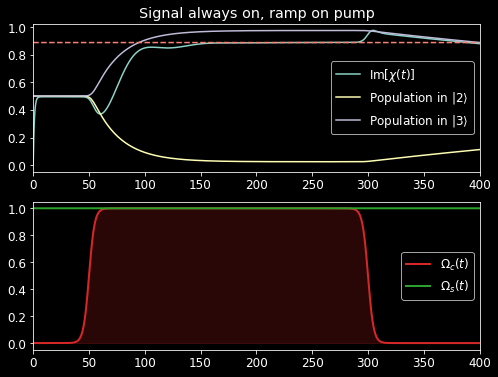

In [5]:
G = 1
Ds = .1*G
Wc = .20*G
Ws = 1e-3 *G
Dc = 0*G

g = G*(1e-3)

Nt = int(4e3)

# Define time Vector
t = np.linspace(0,1,Nt)*400/G

# Initial condition
rho0 = (s22 + s33)/2

# Define time Dependant coefficients
# SIGMOID FUNCTION

t_on = 50
t_off = 300
sig_wd = 2.5

def pulse(t,dummy=False):
    global G, Wc
    return Wc*(1/(1+np.exp(-G*(t-t_on/G)/sig_wd)) - 1/(1+np.exp(-G*(t-t_off/G)/sig_wd)))

# Construct Hamiltonian
H0 = -(Ds*s11 + Ws*(s13 + s31) + (Ds - Dc)*s22)
H1 = -(s12 + s21)
H = [H0,[H1,pulse]]

# ... and solve
result = qt.mesolve(H, rho0,t,[L12,L13,L23,L32],[s31,s22,s33])

fig,(ax1,ax2) = plt.subplots(2,1,figsize = (8,6))


ax1.plot(result.times,np.imag(result.expect[0]/Ws),label = 'Im[$\chi(t)$]')
ax1.plot(result.times,np.real(result.expect[1]),label = 'Population in $\\vert2\\rangle$')
ax1.plot(result.times,np.real(result.expect[2]),label = 'Population in $\\vert3\\rangle$')



# ax2.fill_between(t,np.ones(Nt),alpha = .6,color = 'white')
ax2.fill_between(t,pulse(t)/Wc,alpha = .2,color = 'tab:red')
ax2.plot(t,pulse(t)/Wc,lw =2,color = 'tab:red',label = '$\Omega_c(t)$')
ax2.plot(t,np.ones(Nt),color = 'tab:green',lw=2,label = '$\Omega_s(t)$')

Hss = -(Ds*s11 + Wc*(s12 + s21) + Ws*(s13 + s31) + (Ds - Dc)*s22)
rho_ss = qt.steadystate(Hss,[L12,L13,L23,L32])
chi_ss = rho_ss[0,2]/Ws

ax1.plot(result.times,np.ones(Nt)*np.imag(chi_ss),'--')

ax1.set_title('Signal always on, ramp on pump')

ax1.set_xlim(0,400)
ax2.set_xlim(0,400)
ax1.legend()
ax2.legend();

## Doppler broadened Spectrum

We now move on to compute the Doppler broadened spectra. This is slightly more complicated than with the two level atom because there are multiple fields that each will recieved different Doppler shifts based on their wavelength and their relative direction. We often work in a co-propagating scheme so that the directions are the same. We also work at very similar wavelengths - typically $(\omega_c - \omega_s)/\omega_c \approx \frac{7~\text{GHz}}{350~\text{THz}} \approx 2\times10^{-5}$, so the Doppler shifts are nearly identical. Still however, the shift is applied to each field in the suscetibility so that the result is no longer a simple convolution:

$$
\chi_D = \int_{-\infty}^\infty\chi(\Delta_s-\nu,\Delta_c-\nu,\Omega_c)P_D(\nu)d\nu
$$

As before, we must take care to ensure that each velocity subclass in the integral evaluates the susceptibility in regions where the susceptibility leads to a large contribution or changes rapidly. THis can be done by increasing the density of evaluation points in a small neighborhood about these resonances. For this, there will now be up to two areas where high density will be required: around the doppler shifted 1-photon detuning of the signal, and around the region of 2-photon resonance. Note that these are not necessarily the same regions!

Since this can be cumbersome do take care of inside the integral, We can start by writing a function that produces a variable density frequency range. The goal here is to write an algorithm that takes in a list of ordered pairs that encompass the endpoints of a dense region and ensures that the spacing is dense around these points. The rest of the array will be sparse. This is crucial as a high density of points is required to pick up EIT and Raman transations, but a uniformilly dense sampling will be very inefficient.

Currently user passes low and high frquency (fL,fH) and an set of orderered pairs that are sorted. There can be no overlaps between the the dense regions at the moment but that should be fixed.

TODO: 
 - Sort ordered pairs
 - add variable spacing for dense points
 - condense so that if regions overlap, we are not redundantly counting (in a given region, if double specified, densest spacing wins)

In [6]:
def gen_freaks(fL,fH,sp_sparse,sp_dense=.1,regions=[]):
    '''
    Generates an array from fL to fH with variable spacing.
    regions: contain ordered pairs for wich the spacing is sp_dense (ex [[1.4,2.2],[3.0,5.5]])
    Points not enclosed in a region have a spacing of sp_sparse.
    '''
    nbr_regions = np.shape(regions)[0]
    # print(nbr_regions)
    if nbr_regions == 0: # Edge case: no dense regions
        return np.arange(fL,fH,sp_sparse)
    else:
        curr_region = 0
        fr = np.arange(fL,regions[curr_region][0],sp_sparse)
        while curr_region < nbr_regions-1:
            fr = np.append(fr,np.arange(regions[curr_region][0],regions[curr_region][1],sp_dense))
            fr = np.append(fr,np.arange(regions[curr_region][1],regions[curr_region+1][0],sp_sparse))
            curr_region+=1
        fr = np.append(fr,np.arange(regions[curr_region][0],regions[curr_region][1],sp_dense))
        fr = np.append(fr,np.arange(regions[curr_region][1],fH,sp_sparse))
    return fr

computed in 37.3 s


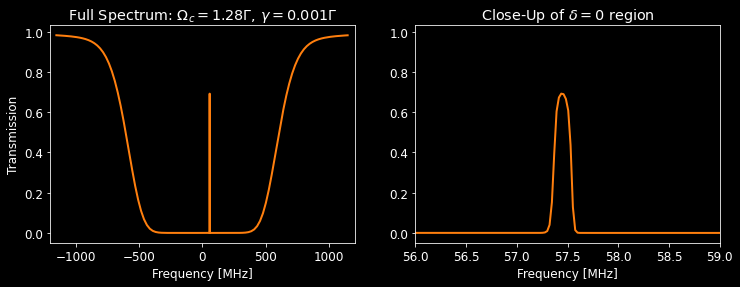

In [7]:
G = alib.GammaRb
Wc = 1.280*G
Ws = 1e-3 *G
Dc = 10*G

g = G*(1e-3)

Lcell = 2.54e-2
T = 330
mRb,lmd = alib.amu*85, alib.lambdaRb87_D2

sD = 2*np.pi*np.sqrt(alib.kB*T/(mRb*lmd**2))
sD =  sD*(G/alib.GammaRb)

Na = alib.getNRb(T)
kz = 2*np.pi*Lcell/alib.lambdaRb87_D1

PF = Na*alib.dRb**2/(alib.hbar*alib.epsilon0)

# Define the detunings over which to scan
spect_lo,spect_hi = -5*sD,5*sD
spect_spacing = 0.1*sD

Dets = gen_freaks(spect_lo,spect_hi,spect_spacing,sp_dense=G/250,regions=[[Dc-G,Dc+G]])
Nspect = len(Dets)
chiD = np.zeros(Nspect)*1j # Placeholder for complex susceptibility

stort = time.time()

# chi = get_chi3lev(f,G/5,DetC=k)

stort = time.time()
for k in range(Nspect):    
    Dops = gen_freaks(-5*sD,5*sD,0.1*G,sp_dense=0.005*G,regions=[[-3*G,+3*G]])
    chi = np.zeros(len(Dops)) + 0j
    for j in range(len(Dops)):
        chi[j] = get_chi3lev_analytic(Dets[k]-Dops[j],RabiC = Wc,DetC = Dc - Dops[j],decoh=g,prefactor = PF)
    Pd = np.exp(-0.5*(Dops/sD)**2)/np.sqrt(2*np.pi*sD**2)
    chiD[k] = np.trapz(chi*Pd,Dops)
    
tim = time.time()-stort
print(f'computed in {round(tim,1)} s')

fig,(ax1,ax2) = plt.subplots(1,2,figsize = [12,4])
ax1.plot(Dets/(2*np.pi*1e6), np.exp(-0.5*kz*np.imag(chiD)),label = 'Absorption',color = 'tab:orange',lw = 2)
ax2.plot(Dets/(2*np.pi*1e6), np.exp(-0.5*kz*np.imag(chiD)),label = 'Absorption',color = 'tab:orange',lw = 2)
ax1.set_ylabel('Transmission')
ax1.set_title('Full Spectrum: $\Omega_c = $'+str(round(Wc/G,2))+'$\Gamma$, $\gamma = $'+str(round(g/G,4))+'$\Gamma$')
ax2.set_title('Close-Up of $\delta=0$ region')
# ax.plot(Dets/(2*np.pi*1e6), kz*np.real(chiD)/(2*np.pi),label = 'Phase $\phi/2\pi$')
ax1.set_xlabel('Frequency [MHz]')
ax1.set_xlim(-1200,1200)
ax2.set_xlabel('Frequency [MHz]')
ax2.set_xlim(56,59);